## packages install

In [1]:
# !pip3 install torch torchvision torchaudio --extra-index-url https: // download.pytorch.org / whl / cpu
# !pip install -U matplotlib

## imports

In [1]:
import os

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import tensor, Tensor
from torch.nn import functional

from train import Mode, ModelManager, DIR_ROOT_SAVE
from utils import plot_img_and_top, get_loader, get_cifar100

# globals
NUM_CLASSES = 100
BATCH_SIZE = 5
NUM_TRAIN = 10
NUM_TEST = 10
ENSEMBLE_SIZE = 10
ENSEMBLE_EPOCHS = 10

NOTEBOOK_NAME = 'el2n'
ENSAMBLE_SAVED_DATA = os.path.join(DIR_ROOT_SAVE, NOTEBOOK_NAME, 'general.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar100()
loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


In [2]:
def get_el2n_scores(y: tensor, ensemble_pred: tensor):
    """
    calculate mean on the L2 over ensemble of algorithms

    :param y: labels, shape: (data len)
    :param ensemble_pred: scores for every data example, shape: (ensemble size, data len, labels len)

    :return: el2n_scores: vector of scores how the example hard to learn for every data
             shape: (data len)
    """
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=ensemble_pred.shape[-1])
    return torch.mean(torch.linalg.norm(y_one_hot - ensemble_pred, ord=2, dim=2), dim=0)

In [7]:
ensemble: list[ModelManager] = [ModelManager(NUM_CLASSES, f'ensemble_{i}', NOTEBOOK_NAME, load=True) for i in
                                range(ENSEMBLE_SIZE)]
ensemble_softmax = torch.empty((len(ensemble), NUM_TRAIN, NUM_CLASSES))
ensemble_pred = torch.empty((NUM_TRAIN, len(ensemble)), dtype=torch.bool)

print()
for i, model_manager in enumerate(ensemble):
    print(f'------------   model {i}   -------------------')
    model_manager.train(loader_train, loader_test, loader_test, 3)
    model_manager.model.cuda()
    scores, pred, loss, acc = model_manager.run_epoch(loader_train_ordered, mode=Mode.TEST)
    pred = pred.cpu()
    scores = scores.cpu()
    ensemble_softmax[i] = functional.softmax(scores, dim=1)
    ensemble_pred[:, i] = torch.Tensor(pred.type(torch.int8) == Y_train)  #.clone().detach().cpu()

ensemble_pred_sum = torch.sum(ensemble_pred, dim=1)
ensemble_std = ensemble_softmax.std(dim=0)
el2n_scores = get_el2n_scores(Y_train, ensemble_softmax)

torch.save(
    {'ensemble_softmax': ensemble_softmax, 'ensemble_pred': ensemble_pred, 'ensemble_pred_sum': ensemble_pred_sum,
     'ensemble_std': ensemble_std, 'el2n_scores': el2n_scores},
    ENSAMBLE_SAVED_DATA)


------------   model 0   -------------------
Epoch: 3 Training: Loss: 1.020039 Acc: 0.100000  Validation Loss: 0.998906 Acc: 0.000000                                              
Epoch: 4 Training: Loss: 0.797734 Acc: 0.100000  Validation Loss: 4.738594 Acc: 0.000000                                              
Epoch: 5 Training: Loss: 0.708789 Acc: 0.200000  Validation Loss: 37.574374 Acc: 0.000000                                                
Test Loss: 37.574374                                                                                                                  
Accuracy: 0.0
------------   model 1   -------------------                                                                                           
Epoch: 3 Training: Loss: 0.987031 Acc: 0.000000  Validation Loss: 1.548281 Acc: 0.000000                                              
Epoch: 4 Training: Loss: 0.754434 Acc: 0.100000  Validation Loss: 5.080781 Acc: 0.000000                                      

In [8]:
data = torch.load(ENSAMBLE_SAVED_DATA)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']

In [9]:
# print(ensemble_softmax[:, 0, :])
# print(ensemble_pred[0])
# print(Y_train[0])
print(el2n_scores[0])
x = el2n_scores[0]
y_hot = torch.nn.functional.one_hot(Y_train[0], num_classes=NUM_CLASSES)
# print(y_hot)
print(((((y_hot - ensemble_softmax[:, 0, :]) ** 2).sum(dim=1)) ** .5).mean())

tensor(1.3876)
tensor(1.3876)


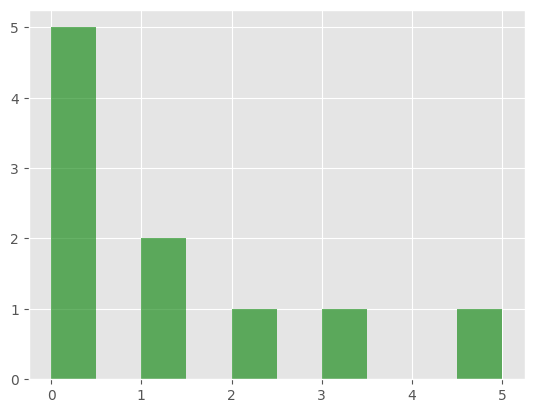

In [10]:
plt.style.use('ggplot')
# plt.figure(figsize=(10, 4))
plt.hist(ensemble_pred_sum, bins=ENSEMBLE_SIZE, facecolor='g', alpha=0.6)
plt.show()

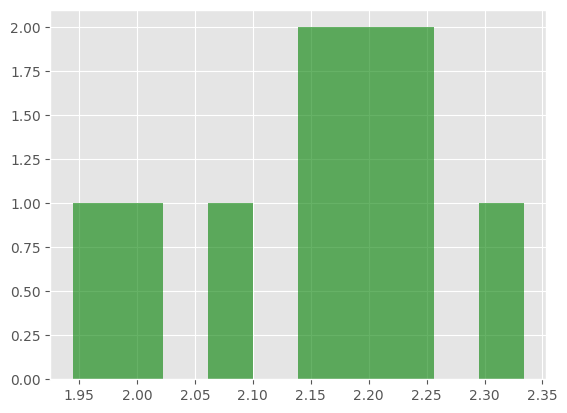

In [11]:
plt.hist(ensemble_std.sum(dim=1), facecolor='g', alpha=0.6)
plt.show()

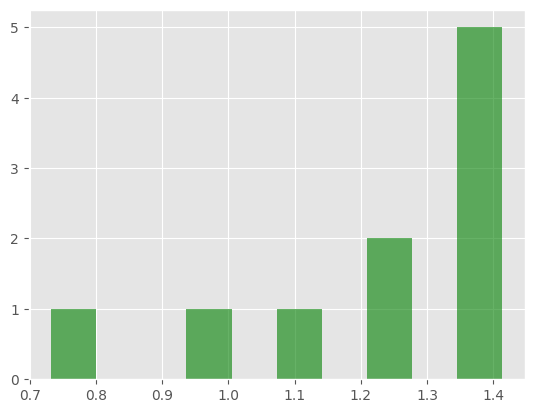

In [12]:
plt.hist(el2n_scores, bins=ENSEMBLE_SIZE, facecolor='g', alpha=0.6)
plt.show()

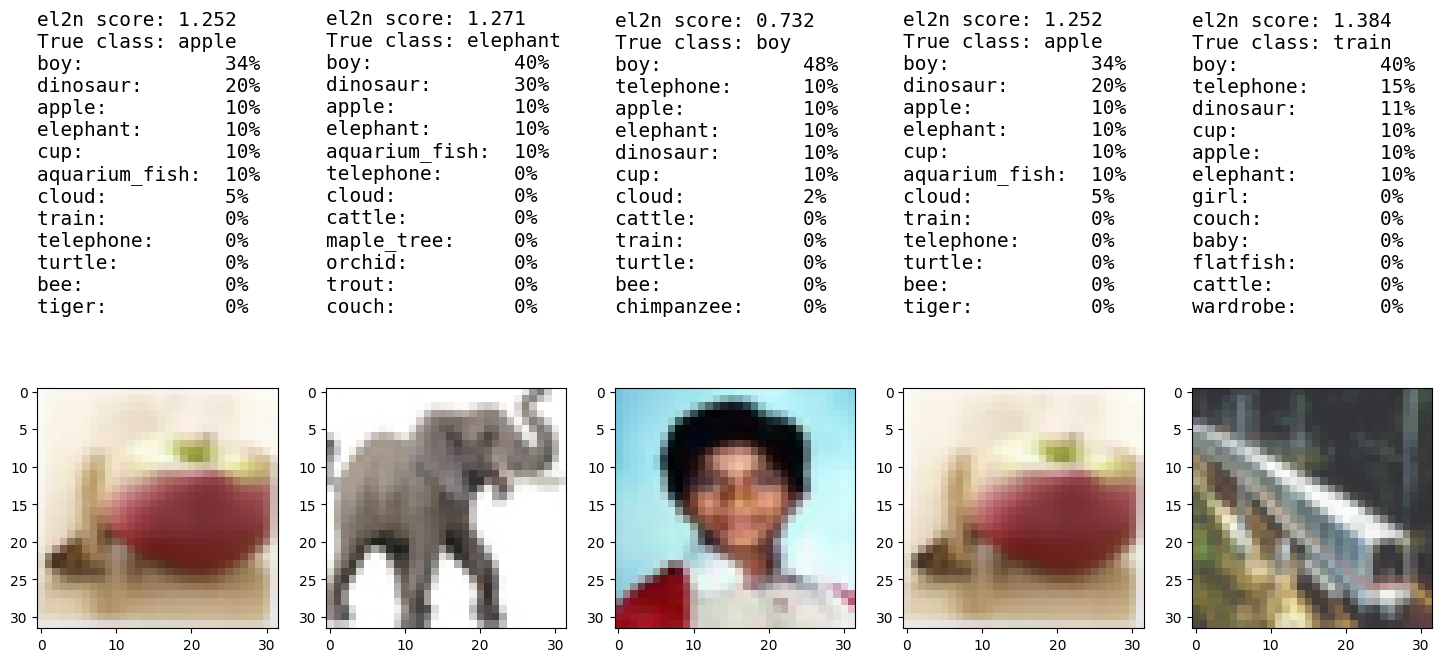

In [13]:
plot_img_and_top(dataset_train_raw, (.0, .99), el2n_scores, ensemble_softmax, ensemble=True, score_name='el2n')
# plot_prune_example(data_train_raw, el2n_scores, hardest=True, prune_method_name='EL2N', random=False)
# plot_prune_example(data_train_raw, el2n_scores, hardest=False, prune_method_name='EL2N', random=False)

In [11]:
# dataset_train, dataset_test = get_cifar(PATH_DATASETS)
# loader_test = get_loader(dataset_test, np.arange(NUM_TEST), BATCH_SIZE, False)
# # remove 1% the hardest examples
# NUM_TRAIN = int(NUM_TRAIN * .99)
# idx_sorted_to_train = el2n_scores.sort()[1].numpy()[:NUM_TRAIN]

In [29]:
def pred_ensamble(ensemble_, loader, Y):
    len_dataset = len(loader.dataset)

    en_scores = torch.empty((len(ensemble_), len_dataset, NUM_CLASSES))
    en_pred = torch.empty((len(ensemble_), len_dataset))

    for model_manager_ in ensemble_:
        model_manager.model.cuda()
        scores_, pred_, loss_, acc_ = model_manager_.run_epoch(loader, mode=Mode.TEST)
        en_scores[i] = scores_.cpu()
        en_pred[i] = torch.Tensor(pred_.cpu().type(torch.int8) == Y)

    scores_mean = en_scores.mean(dim=0)
    pred_mean = torch.max(scores_mean, 1)[1]
    acc_ = torch.sum(pred_mean.eq(Y)).item() / len_dataset

    print(acc_)


pred_ensamble(ensemble, loader_test, Y_test)

0.311                                                                                                                                   


# 1. every 2 epochs add the next group of hard to dataset

In [13]:
# model_manager = ModelManager(NUM_CLASSES, 'el2n_simple_to_hard', load=False)
#
# print()
# idx = np.array([], dtype=int)
# for subset in np.array_split(idx_sorted_to_train, 10):
#     print(f'====     Train on {(len(idx) + len(subset)) / NUM_TRAIN:.0%} simplest     ======')
#     loader_train = get_loader(dataset_train, idx := np.append(idx, subset), BATCH_SIZE, True)
#     model_manager.train(loader_train, loader_test, loader_test, 3)
#
#     print()

# 2. same as 1 but remove 50% of last group

In [14]:
# model_manager = ModelManager(NUM_CLASSES, 'el2n_simple_to_hard_50p', load=False)
#
# print()
# idx = np.array([], dtype=int)
# for subset in np.array_split(idx_sorted_to_train, 10):
#     print(f'====    Train on {(len(idx) + len(subset)) / NUM_TRAIN:.0%} simplest     ======')
#
#     loader_train = get_loader(dataset_train, np.append(idx, subset), BATCH_SIZE, True)
#     model_manager.train(loader_train, loader_test, loader_test, 3)
#
#     idx = np.append(idx, np.random.choice(subset, len(subset) // 2, replace=False))
#
#     print()

# 3. train only 50% of the simplest examples

In [15]:
# model_manager = ModelManager(NUM_CLASSES, 'el2n_easiest', load=False)
#
# loader_train = get_loader(dataset_train, idx_sorted_to_train[:NUM_TRAIN // 2], BATCH_SIZE, True)
# print()
# model_manager.train(loader_train, loader_test, loader_test, EPOCHS)

# 4. train 9 models each with 10% less easy train examples

In [16]:
# models = []
#
# print()
# loss, acc, prune_size = [], [], []
# idx = np.array([], dtype=int)
#
# for subset in np.array_split(idx_sorted_to_train, 10):
#     idx = np.append(idx, subset)
#     prcent = len(idx) / NUM_TRAIN
#     print(f'====     train model with {prcent:.0%} most hard     ======')
#     loader_train = get_loader(dataset_train, idx, BATCH_SIZE, True)
#
#     model_manager = ModelManager(NUM_CLASSES, f'el2n_{int(prcent * 100)}p_hard', dir_='el2n_p_hard', load=False)
#     model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
#
#     models.append(model_manager)
#     prune_size.append(prcent), acc.append(model_manager.data['test']['acc']), loss.append(
#         model_manager.data['test']['loss'])
#     print()
#
# ModelManager.save_models_log(models, 'el2n_p_hard')

In [17]:
# fig, axes = plt.subplots(1, 2, figsize=(17, 4))
# axes[0].plot(prune_size, loss)
# axes[0].set_xlabel('prune size')
# axes[0].set_ylabel('Loss')
# axes[1].plot(prune_size, acc)
# axes[1].set_xlabel('prune size')
# axes[1].set_ylabel('Acc')
# fig.subplots_adjust(wspace=.4)
# plt.plot()

# 5.

In [18]:
# models = []
#
# print()
# loss, acc, prune_size = [], [], []
# idx = np.array([], dtype=int)
#
# for subset in np.array_split(idx_sorted_to_train[::-1], 10):
#     idx = np.append(idx, subset)
#     prcent = len(idx) / NUM_TRAIN
#     print(f'====     train model with {prcent:.0%} most hard     ======')
#     loader_train = get_loader(dataset_train, idx, BATCH_SIZE, True)
#
#     model_manager = ModelManager(NUM_CLASSES, f'el2n_{int(prcent * 100)}p_hard_', dir_='el2n_p_hard_', load=False)
#     model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
#
#     models.append(model_manager)
#     prune_size.append(prcent), acc.append(model_manager.data['test']['acc']), loss.append(
#         model_manager.data['test']['loss'])
#     print()
#
# ModelManager.save_models_log(models, 'el2n_p_hard_')

In [19]:
# fig, axes = plt.subplots(1, 2, figsize=(17, 4))
# axes[0].plot(prune_size, loss)
# axes[0].set_xlabel('prune size')
# axes[0].set_ylabel('Loss')
# axes[1].plot(prune_size, acc)
# axes[1].set_xlabel('prune size')
# axes[1].set_ylabel('Acc')
# fig.subplots_adjust(wspace=.4)
# plt.plot()

In [20]:
# E, T, C = 2, 3, 4
# s = np.arange(E * T * C, dtype=float).reshape((E, T, C))
# print(torch.from_numpy(s).mean(dim=0))